In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from GetData import get_train, get_test

In [2]:
train = get_train()
test = get_test()
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [3]:
features = [x for x in train.columns if x not in ['id','loss']]
#print(features)

cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

# Target Variable Distribution

<AxesSubplot:>

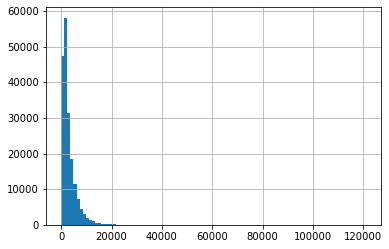

In [4]:
train["loss"].hist(bins = 100)

The target variable is not very symmetrical (left-skewed), which is what RMSE based algorithms really need to perform accurate predictions. Let's try transforming the target to get a better outcome.

# Lognormal Transformation of the Target Variable

<AxesSubplot:>

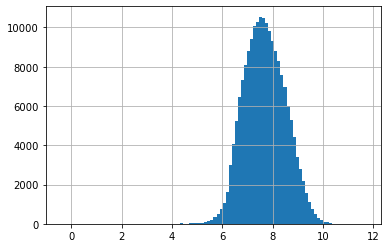

In [5]:
train["log_loss"] = np.log(train["loss"])
train["log_loss"].hist(bins = 100)

This target variable is way more symmetrical, which will allow for better modeling.

# Data Preparation

We will utilize ordinal encoding of the categorical features

In [6]:
categorical = train.loc[:, train.columns.str.startswith("cat")]
continuous = train.loc[:, train.columns.str.startswith("cont")]

cat_columns = categorical.columns.to_list()
cont_columns = continuous.columns.to_list()

## Continuous Variable Correlations with Log(loss)

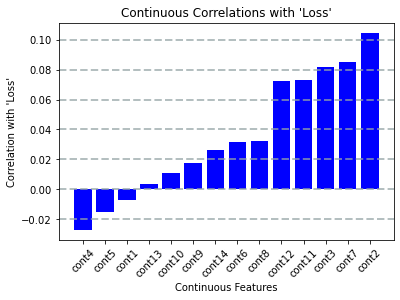

In [7]:
cont_correlation = continuous.copy()
cont_correlation["log_loss"] = train.loc[: ,"log_loss"]
corr = cont_correlation.corr()
corr = corr["log_loss"].drop("log_loss").sort_values()

# Create a bar plot of continuous feature correlation with target 'loss'
plt.bar(x = corr.index,  height = corr, color = "blue")
plt.title("Continuous Correlations with 'Loss'")
plt.xlabel('Continuous Features')
plt.ylabel("Correlation with 'Loss'")
plt.grid(color = '#95a5a6', linestyle = '--', linewidth = 2, axis = 'y', alpha = 0.7)
plt.xticks(rotation = 45)
plt.show()

In [8]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Categorical Variable Pipe
cat_pipe = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown= "True")),
    ('skb',SelectKBest(f_regression, k = 'all'))
])

# Column transformer, will need to set remainder = 'passthrough'
full_pipeline = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),
    ("num",'passthrough' ,cont_columns)
])

In [9]:
X = train.drop(["loss", "log_loss"], axis = 1)
y = train["log_loss"]

X_prepared = full_pipeline.fit_transform(X, y)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prepared,y,test_size = 0.2)

# Modeling

> **SUMMARY** To get out predictions, we will average three boosting models (XGBoost, LGBM and CatBoost)

In [11]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [12]:
# Initiate Models
model_xgb = XGBRegressor()
model_cat = CatBoostRegressor()
model_lgbm = LGBMRegressor()

In [13]:
# Train Models
model_xgb.fit(X_train,y_train)
model_cat.fit(X_train,y_train)
model_lgbm.fit(X_train, y_train)

Learning rate set to 0.095297
0:	learn: 0.7857470	total: 167ms	remaining: 2m 46s
1:	learn: 0.7630957	total: 185ms	remaining: 1m 32s
2:	learn: 0.7430277	total: 205ms	remaining: 1m 8s
3:	learn: 0.7254351	total: 223ms	remaining: 55.4s
4:	learn: 0.7106328	total: 240ms	remaining: 47.8s
5:	learn: 0.6968402	total: 257ms	remaining: 42.5s
6:	learn: 0.6851612	total: 275ms	remaining: 39s
7:	learn: 0.6753455	total: 299ms	remaining: 37.1s
8:	learn: 0.6665246	total: 317ms	remaining: 34.9s
9:	learn: 0.6588727	total: 339ms	remaining: 33.6s
10:	learn: 0.6518224	total: 365ms	remaining: 32.8s
11:	learn: 0.6459076	total: 385ms	remaining: 31.7s
12:	learn: 0.6395854	total: 402ms	remaining: 30.5s
13:	learn: 0.6346898	total: 420ms	remaining: 29.6s
14:	learn: 0.6303653	total: 438ms	remaining: 28.8s
15:	learn: 0.6264705	total: 455ms	remaining: 28s
16:	learn: 0.6227063	total: 485ms	remaining: 28.1s
17:	learn: 0.6192280	total: 504ms	remaining: 27.5s
18:	learn: 0.6156650	total: 532ms	remaining: 27.5s
19:	learn: 0.

LGBMRegressor()

In [14]:
# Get Predictions for evaluating training set
xgb_preds = model_xgb.predict(X_test)
cat_preds = model_cat.predict(X_test)
lgbm_preds = model_lgbm.predict(X_test)

In [15]:
# Average predictions
preds = (xgb_preds + cat_preds + lgbm_preds) / 3

# Transform Predictions
preds = np.exp(preds - 1)

# Transform target
y_test_loss = np.exp(y_test - 1)

In [16]:
# Compute Accuracy
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_loss, preds)
RMSE = np.sqrt(mse)
RMSE

722.0104758117948

# Deploy model on test data

In [17]:
test_prepared = full_pipeline.transform(test)

In [18]:
# Get predictions
xgb_preds_test = model_xgb.predict(test_prepared)
cat_preds_test = model_cat.predict(test_prepared)
lgbm_preds_test = model_lgbm.predict(test_prepared)

# Average Predictions
final_preds = (xgb_preds_test + cat_preds_test + lgbm_preds_test) / 3

# Final Preds
final_preds_transformed = np.exp(final_preds - 1)

In [20]:
from GetData import get_sub
df_sub = get_sub()

In [21]:
df_sub["loss"] = final_preds_transformed

In [23]:
df_sub.to_csv("Result.csv")